# Text Mining and Search Project

Raffaele Anselmo - 846842

Lorenzo Pastore - 847212

## Import Libraries

In [0]:
#Generic libraries to import, handle and managing datasets
import pandas as pd
import numpy as np
import json
import gzip

#visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image


#natural language processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

#handle sparse matrices
from scipy import sparse

#sklearn libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer #Tf-idf and BoW representation
from sklearn.decomposition import PCA #matrix decomposition
from sklearn.feature_selection import SelectKBest, chi2 #feature selection
#Neural Network utilities
from sklearn.neural_network import MLPClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics

#tracking time
import time
# loanding url
import urllib.request

seed = np.random.RandomState(126)

## Import files and conversion in Pandas Dataframes

In [2]:
start = time.time()

# Digital Music file
url = 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Digital_Music_5.json.gz'
urllib.request.urlretrieve(url, "DM.gz")

# All Beauty Reviews file
url = 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty_5.json.gz'
urllib.request.urlretrieve(url, "AB.gz")

# Software Reviews file
url = 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Software_5.json.gz'
urllib.request.urlretrieve(url, "SW.gz")

# Gift Cards file
url = 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Gift_Cards_5.json.gz'
urllib.request.urlretrieve(url, "GC.gz")

# Luxury beauty Reviews file
url = 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Luxury_Beauty_5.json.gz'
urllib.request.urlretrieve(url, "LB.gz")

# Appliances Reviews file
url = 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Appliances_5.json.gz'
urllib.request.urlretrieve(url, "AP.gz")

# Magazine Subscription Reviews file
url = 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Magazine_Subscriptions_5.json.gz'
urllib.request.urlretrieve(url, "MS.gz")

end = time.time()
print('loanding time:',(end-start), 'seconds')

loanding time: 9.782432317733765 seconds


In [0]:
#Loading dataframe functions
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [0]:
# DIGITAL MUSIC
df_dm = getDF('DM.gz')
# sampling 2,000 reviews
df_dm = df_dm.sample(n=2000, random_state=seed)
df_dm['Class'] = 'Digital_Music'

# ALL BEAUTY
df_ab = getDF('AB.gz')
# sampling 2,000 reviews
df_ab = df_ab.sample(n=2000, random_state=seed)
df_ab['Class'] = 'All_Beauty'

# SOFTWARE
df_sf = getDF('SW.gz')
# sampling 2,000 reviews
df_sf = df_sf.sample(n=2000, random_state=seed)
df_sf['Class'] = 'Software'

# GIFT CARDS
df_gc = getDF('GC.gz')
# sampling 2,000 reviews
df_gc = df_gc.sample(n=2000, random_state=seed)
df_gc['Class'] = 'Gift_Cards'

# LUXURY BEAUTY
df_ps = getDF('LB.gz')
# sampling 2,000 reviews
df_ps = df_ps.sample(n=2000, random_state=seed)
df_ps['Class'] = 'Luxury_Beauty'

# APPLIANCES
df_ap = getDF('AP.gz')
# sampling 2,000 reviews
df_ap = df_ap.sample(n=2000, random_state=seed)
df_ap['Class'] = 'Appliances'

# MAGAZINE SUBSCRIPTION
df_ms = getDF('MS.gz')
# sampling 2,000 reviews
df_ms = df_ms.sample(n=2000, random_state=seed)
df_ms['Class'] = 'Magazine_sub'

In [0]:
#Creating main dataframe
frames = [df_dm, df_ab, df_sf, df_gc, df_ps, df_ap, df_ms]
df = pd.concat(frames, axis=0, sort=False)
df = df[['reviewText','Class']]
df.to_csv('dataframe_complete.csv')

In [6]:
df.shape

(14000, 2)

## Preprocessing

In [0]:
#Creating dictionary for future use
df['category_id'] = df['Class'].factorize()[0]
category_id_df = df[['Class', 'category_id']].drop_duplicates()
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Class']].values)

In [8]:
df.shape

(14000, 3)

In [9]:
#download tokenization,stopwords and stemming packages
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 
tokenizer = RegexpTokenizer(r'\w+')
porter = nltk.PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#Defining a compact preprocessing function
def preprocess(single_doc):
    #removing all but characters
    single_doc = re.sub(r'[^A-Za-z]+', " ", single_doc)
    #normalization to lower case
    single_doc = single_doc.lower()
    single_doc = single_doc.strip()
    #removing n-duplicate characters (n>2)
    single_doc = re.sub(r'([a-z])\1+', r'\1\1', single_doc)
    #tokenization
    tokens = tokenizer.tokenize(single_doc)
    #stopwords removal 
    filtered_tokens = [token for token in tokens if token not in stop_words]
    #stemming
    stemmed = [porter.stem(y) for y in filtered_tokens]
    #reconstruct document
    single_doc = ' '.join(stemmed)
    return single_doc

In [11]:
start = time.time()
#Preprocess review's text
reviews = df['reviewText'].astype(str)
norm_docs = np.vectorize(preprocess)
normalized_documents = norm_docs(reviews)
#
end = time.time()
print('Execution time:',(end-start), 'seconds')

Execution time: 13.864601612091064 seconds


## Text Representation

### Bag of Words 

In [12]:
BoW_vector = CountVectorizer()
BoW_Matrix = BoW_vector.fit_transform(normalized_documents).toarray()
features = BoW_vector.get_feature_names()
BoW_df = pd.DataFrame(BoW_Matrix, columns=features)
BoW_df.head()

,aa,aargh,aarn,aaron,aarp,aawp,ab,aback,abandon,abbey,abbi,abc,abdomen,abduct,abhorr,abid,abil,abl,ablum,abnorm,aboard,aboaut,abod,abomin,abort,abound,abr,abras,abravanel,abreast,abroad,abrupt,abruptli,absenc,absent,absolu,absolut,absolutel,absorb,absorpt,...,zegna,zem,zent,zeppelin,zero,zi,zigzag,zillion,zinc,zine,zip,zipper,zippo,zipsend,zipshar,zipx,zirh,zit,zombi,zone,zonealarm,zoneedit,zonelab,zoom,zorin,zorro,zoviet,zoya,zqkq,zr,zs,ztw,zubi,zum,zumba,zumbon,zune,zurich,zwill,zz
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Top 400 tokens in Amazon Reviews')

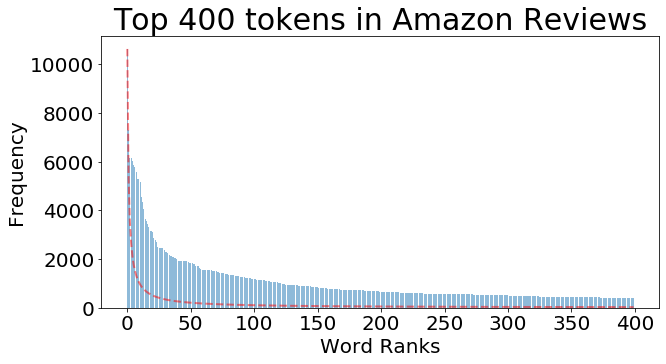

In [13]:
#calculating words frequencies
word_freq = BoW_df.sum(axis=0).sort_values(ascending=False)
#checking for zipfian distribution
word_ranks = np.arange(400)
plt.figure(figsize=(10,5))
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
s=1
expected_zipf = [word_freq[:400][0]/(i+1)**s for i in word_ranks]
plt.bar(word_ranks, word_freq[:400], align='center', alpha = 0.5)
plt.plot(word_ranks, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Word Ranks', fontsize=20)
plt.title('Top 400 tokens in Amazon Reviews', fontsize=30)

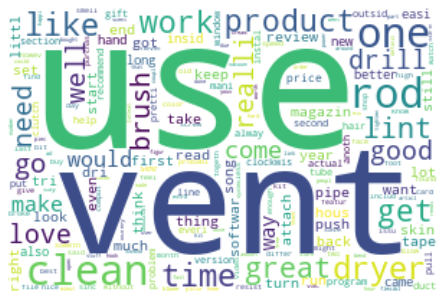

In [14]:
#Visualizing amazon wordcloud
#amazon = np.array(Image.open("amazon_logo.png"))
wordcloud = WordCloud(
    width = 300,
    height = 200,
    background_color = 'white', 
    #mask =amazon,
    )
wordcloud.generate_from_frequencies(word_freq)
fig = plt.figure(
    facecolor = 'w',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Text(0.5, 1.0, 'Top 30 tokens in Amazon Reviews')

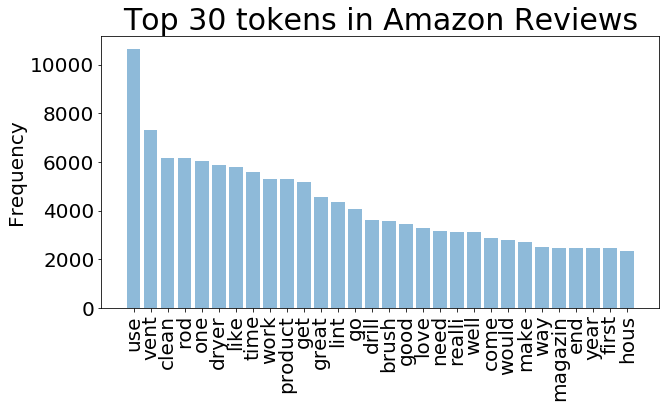

In [15]:
#Visualizing top 30 tokens in Amazon's reviews
word_ranks = np.arange(30)
plt.figure(figsize=(10,5))
plt.bar(word_ranks, word_freq[:30], align='center', alpha = 0.5)
plt.xticks(word_ranks, word_freq[:30].index, rotation='vertical')
plt.ylabel('Frequency', fontsize=20)
plt.title('Top 30 tokens in Amazon Reviews', fontsize=30)

### TF-IDF 

In [16]:
start = time.time()
#Creating a tf-idf representation of unigram and bigram
tf_idf_vector = TfidfVectorizer(sublinear_tf=True,
                                min_df=5)
#Using the tf-idf with the preprocessed dataset
tf_idf_Matrix = tf_idf_vector.fit_transform(normalized_documents)
features_tf = tf_idf_vector.get_feature_names()
#Conversion to array
tf_idf_Matrix = tf_idf_Matrix.toarray()
feature_array = np.array(features_tf)
#Conversion to DataFrame
tf_idf_array = pd.DataFrame(tf_idf_Matrix, columns = feature_array)
tf_idf_array.head()

end = time.time()
print("TF-IDF dimensions: ", tf_idf_Matrix.shape)
print('Execution time:',(end-start), 'seconds')

TF-IDF dimensions:  (14000, 4852)
Execution time: 1.2605597972869873 seconds


In [17]:
#Visualization of most correlated word using TF-IDF representation
features = tf_idf_Matrix
labels = df.category_id

N = 3
for Class, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tf_idf_vector.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  print("\n==> %s:" %(Class))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))


==> All_Beauty:
  * Most Correlated Unigrams are: hair, smell, shampoo

==> Appliances:
  * Most Correlated Unigrams are: lint, dryer, vent

==> Digital_Music:
  * Most Correlated Unigrams are: album, music, song

==> Gift_Cards:
  * Most Correlated Unigrams are: christma, card, gift

==> Luxury_Beauty:
  * Most Correlated Unigrams are: polish, skin, color

==> Magazine_sub:
  * Most Correlated Unigrams are: recip, articl, magazin

==> Software:
  * Most Correlated Unigrams are: instal, program, softwar


## Dimensionality Reduction
 1. Features Selection with chi2 test
 2. Features Synthetization with PCA

In [0]:
#reset indexes
y = df['Class']
y = y.reset_index()
y = y['Class']

### Features Selection

In [19]:
#FEATURE SELECTION
start = time.time()
#Maintaining only 75% of best features according to chi2 independence test
k = int(tf_idf_Matrix.shape[1]*0.75) 
sel_chi2 = SelectKBest(chi2, k=k)
# saving matrix
tf_idf_reduced = sel_chi2.fit_transform(tf_idf_Matrix, y)
print('TF-IDF matrix reduced dim:',tf_idf_reduced.shape)

end = time.time()
print('Execution time:',(end-start), 'seconds')

TF-IDF matrix reduced dim: (14000, 3639)
Execution time: 1.4092817306518555 seconds


### Features Synthetization

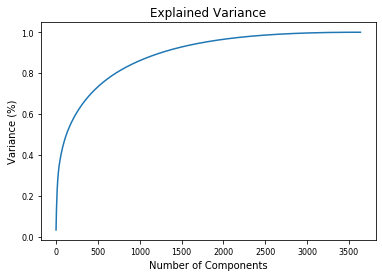

Execution time: 67.87215089797974 seconds


In [20]:
#FEATURE SYNTHETIZATION
start = time.time()
pca = PCA()
pca.fit(tf_idf_reduced)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

end = time.time()
print('Execution time:',(end-start), 'seconds')

In [21]:
#maintaining only 2000 components that can explain more than 90% of the tot variance
pca = PCA(n_components = 2000)
start = time.time()
matrix_reduced = pca.fit_transform(tf_idf_Matrix)
end = time.time()
print('Execution time:',(end-start), 'seconds')
print('PCA matrix reduced dim:',matrix_reduced.shape)

Execution time: 109.9993109703064 seconds
PCA matrix reduced dim: (14000, 2000)


## Classification with sklearn

In [22]:
#Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(matrix_reduced,y, test_size=0.1,
                                                    random_state = seed)
print('Train examples:', X_train.shape[0])
print('Test examples:', X_test.shape[0])

Train examples: 12600
Test examples: 1400


### SVC

In [23]:
CV = 5
svc = LinearSVC()
start = time.time()
results_svc = cross_val_score(svc, X_train, Y_train, scoring='accuracy', cv=CV)
end = time.time()
results_svc
print('Execution time:',(end-start), 'seconds')

Execution time: 50.52106046676636 seconds


### Logistic Regression

In [24]:
lr = LogisticRegression(random_state=seed, max_iter=500)
start = time.time()
results_lr = cross_val_score(lr, X_train, Y_train, scoring='accuracy', cv=CV)
end = time.time()
results_lr
print('Execution time:',(end-start), 'seconds')

Execution time: 70.43296265602112 seconds


### MultiLayerPerceptron

In [25]:
mlp = MLPClassifier(hidden_layer_sizes=(100,50,50,50), 
                      activation='relu',
                      solver='adam',
                      max_iter=500)
start = time.time()
results_mlp = cross_val_score(mlp, X_train, Y_train, scoring='accuracy', cv=CV)
end = time.time()
results_mlp
print('Execution time:',(end-start), 'seconds')

Execution time: 450.23638129234314 seconds


### Results Comparison

In [0]:
acc = pd.DataFrame(data=(results_svc, results_lr, results_mlp), index= ("SVC", "LR", "MLP"))

In [0]:
mean_accuracy = acc.mean(axis=1)
std_accuracy = acc.std(axis=1)
results = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
results.columns = ['Mean Accuracy', 'Standard deviation']

In [28]:
results

,Mean Accuracy,Standard deviation
SVC,0.864603,0.005393
LR,0.859127,0.008966
MLP,0.830159,0.009676


### Prediction on Test Set with SVC

In [29]:
model = LinearSVC()
model.fit(X_train, Y_train)

start = time.time()
test_pred = model.predict(X_test)
end = time.time()
print('Classification costs:',(end-start), 'seconds')

Classification costs: 0.008883237838745117 seconds


In [30]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(Y_test, test_pred, 
                                    target_names= df['Class'].unique()))

				CLASSIFICATIION METRICS

               precision    recall  f1-score   support

Digital_Music       0.81      0.79      0.80       199
   All_Beauty       1.00      0.97      0.98       183
     Software       0.86      0.87      0.86       202
   Gift_Cards       0.75      0.88      0.81       210
Luxury_Beauty       0.85      0.83      0.84       204
   Appliances       0.92      0.88      0.90       214
 Magazine_sub       0.95      0.88      0.92       188

     accuracy                           0.87      1400
    macro avg       0.88      0.87      0.87      1400
 weighted avg       0.87      0.87      0.87      1400

